<a href="https://colab.research.google.com/github/DavisGlen/analyzing-ecommerce-data/blob/main/analyzing_ecom.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Ecommerce businesses must make decisions in real time about how to spend their advertising budgets to increase store revenue. In this project, I analyze an 8.39 GB csv file in "real-time" using a basic "Kafka" message broker produced by my project leader, Leon Staubach. As view and purchase events come in, I update our parameters based on the category of the item. I periodically display the output using a graph so that the owner of the store can see how much revenue each page view generates on average.

In a real use case, the next step would be to analyze average Cost of Goods Sold per purchase. While we don't have access to this data in the dataset, the owner of the store could easily access this data, so it is a natural next step. This update would let us determine profit per purchase instead of revenue only.

Another update we could make is automating ad purchasing decisions such as increasing our Google advertising bids when the revenue per view is higher. There are many use cases for this dashboard that cannot currently be automated, though, such as deciding which categories to write SEO content for or which categories to highlight in email marketing campaigns, making the visual display the currently preferred output.

One key assumption made in this analysis is that a paid view at the top of the funnel roughly translates to a view in this dataset. It is likely that the average viewer already on our website is more likely to make a purchase compared to the average random viewer advertised to on the internet, meaning we would be overspending on advertising. On the other hand, one visitor to the website will have multiple page views meaning that the top of the funnel page view may actually be more valuable than this analysis shows. One way to combat this would be to analyze user sessions instead of views, but our assumption leads to both an over and an underestimation which will hopefully cancel out somewhat. Furthermore, the ratios of our analysis will be the same, so given a fixed advertising budget and cost per page visit on an advertising service, we can still spend our advertising budget in an optimal way.

I want to give a huge thanks to my project leader, Leon Staubach, for his help in this project. Before this project, I had zero experience in real-time data analysis, and he was always extremely patient in helping me understand the next steps. He also had super fun topics to teach us every week like the importance of explainability in ML models or using sin/cos space for numerical features with cyclical proerties. I also want to thank Phillip Park and Regina Paek for their willingness to share their progress every week so that we could all learn from each other.

In [ ]:
import pandas as pd
import numpy as np
import csv
from datetime import datetime
import matplotlib.pyplot as plt
from threading import Thread, Lock

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


This data is from Kaggle and can be found at this link:

https://www.kaggle.com/datasets/mkechinov/ecommerce-behavior-data-from-multi-category-store/code?select=2019-Nov.csv

If you'd like to follow along, download this large csv file to your Google Drive and make sure it is named '2019-Nov.csv'.

In [ ]:
%cd /content/drive/MyDrive/

/content/drive/MyDrive


In [ ]:
%ls

 2019-Nov.csv         'Host Hive Lead Gen.gsheet'
'9 29.gdoc'            secret.gdoc
'Colab Notebooks'/     ToDo.gsheet
'David Perez.gdoc'    'Untitled drawing.gdraw'
 experiences.gsheet   'Untitled presentation.gslides'
'Grant Writing.gdoc'  'UPenn Fin Modeling.gsheet'


The below code block is from my Project Leader, Leon Staubach with some updates. This code is meant to mimc Kafka in a simplified fashion so that the csv file could be analyzed as if the data were coming in real-time.

In [ ]:
# Code from Leon Staubach, Project Leader

import threading
import time
from queue import Queue

class Message:

    def __init__(self, item_category):
        self.item_category = item_category
        self.mtype = "basic"

    def __str__(self):
        return f"Message:\n\tItem Category: {self.item_category}"

class ViewMessage(Message):

    def __init__(self, item_category):
      super().__init__(item_category)
      self.mtype = "view"
    
  
    def __str__(self):
        return f"View Message:\n\tItem Category: {self.item_category}"


class PurchaseMessage(Message):
  
    def __init__(self, item_category, price):
      super().__init__(item_category)
      self.price = price
      self.mtype = "purchase"

    def __str__(self):
        return f"Purchase Message:\n\tItem Category: {self.item_category}\n\tPrice: {self.price}"


class KafkaBroker:
    def __init__(self, topic):
        self.topic = topic
        self.data = {}

    def produce_message(self, message: Message):
  
        if self.topic in self.data:
            self.data[self.topic].append(message)
        else:
            self.data[self.topic] = [message]

    def consume_messages(self):
        while True:
            if self.topic in self.data and len(self.data[self.topic]) > 0:
                message = self.data[self.topic].pop(0)
                yield message
            # time.sleep(1)

class KafkaProducer:
    def __init__(self, broker, topic):
        self.broker = broker
        self.topic = topic

    def send(self, message: Message):
        self.broker.produce_message(message)

class KafkaConsumer:
    def __init__(self, broker, topic):
        self.broker = broker
        self.topic = topic
        self.queue = Queue()
        self.thread = threading.Thread(target=self.run)
        self.thread.start()

    def run(self):
        for message in self.broker.consume_messages():
            self.queue.put(message)

    def poll(self, timeout=1):
        try:
            return self.queue.get(timeout=timeout)
        except:
            return None

if __name__ == "__main__":
    broker = KafkaBroker('test_topic')
    producer = KafkaProducer(broker, 'test_topic')
    consumer = KafkaConsumer(broker, 'test_topic')

    producer.send(ViewMessage("appliance"))
    producer.send(PurchaseMessage("computer", 1000))

    timeoutSeconds = 5
    start_time = time.time()
    while (time.time() - start_time) < timeoutSeconds:

        time.sleep(0.2)
        
        # Instead of printing, you can pass the message on to your processing class
        print(consumer.poll())

View Message:
	Item Category: appliance
Purchase Message:
	Item Category: computer
	Price: 1000
None
None
None
None


In [ ]:
types = set()

with open("2019-Nov.csv") as csvfile:
  count = 0 
  for row in csvfile:
    # row_arr = row.split(",")
    # types.add(row_arr[1])
    print(row)
    count = count + 1
    if count % 100 == 0:
      break

event_time,event_type,product_id,category_id,category_code,brand,price,user_id,user_session

2019-11-01 00:00:00 UTC,view,1003461,2053013555631882655,electronics.smartphone,xiaomi,489.07,520088904,4d3b30da-a5e4-49df-b1a8-ba5943f1dd33

2019-11-01 00:00:00 UTC,view,5000088,2053013566100866035,appliances.sewing_machine,janome,293.65,530496790,8e5f4f83-366c-4f70-860e-ca7417414283

2019-11-01 00:00:01 UTC,view,17302664,2053013553853497655,,creed,28.31,561587266,755422e7-9040-477b-9bd2-6a6e8fd97387

2019-11-01 00:00:01 UTC,view,3601530,2053013563810775923,appliances.kitchen.washer,lg,712.87,518085591,3bfb58cd-7892-48cc-8020-2f17e6de6e7f

2019-11-01 00:00:01 UTC,view,1004775,2053013555631882655,electronics.smartphone,xiaomi,183.27,558856683,313628f1-68b8-460d-84f6-cec7a8796ef2

2019-11-01 00:00:01 UTC,view,1306894,2053013558920217191,computers.notebook,hp,360.09,520772685,816a59f3-f5ae-4ccd-9b23-82aa8c23d33c

2019-11-01 00:00:01 UTC,view,1306421,2053013558920217191,computers.notebook,hp,514.5

In [ ]:
class DataProcess:

  def __init__(self):
    self.analysis_dict = {}
    self.lock = Lock()
  
  def process_view(self, vMsg: ViewMessage):

    self.lock.acquire()

    try:
      if vMsg.item_category in self.analysis_dict:
        self.analysis_dict[vMsg.item_category]["num_views"] = self.analysis_dict[vMsg.item_category]["num_views"] + 1
      else:
        first_row = {
            "num_views": 1,
            "num_purchases": 0,
            "total_revenue": 0.0
        }
        self.analysis_dict[vMsg.item_category] = first_row
      self.lock.release()
    except:
      self.lock.release()
    
    
  def process_purchase(self, pMsg: PurchaseMessage):

    self.lock.acquire()

    try:
      if pMsg.item_category in self.analysis_dict:
        self.analysis_dict[pMsg.item_category]["num_purchases"] = self.analysis_dict[pMsg.item_category]["num_purchases"] + 1
        self.analysis_dict[pMsg.item_category]["total_revenue"] = self.analysis_dict[pMsg.item_category]["total_revenue"] + float(pMsg.price)
      else:
        first_row = {
            "num_views": 0,
            "num_purchases": 1,
            "total_revenue": float(pMsg.price)
        }
        self.analysis_dict[pMsg.item_category] = first_row
      self.lock.release()
    except: 
      self.lock.release()
  
  def get_cur_dataframe(self):
    self.lock.acquire()
    try:
      temp_df = pd.DataFrame(self.analysis_dict)
      self.lock.release()
    except: 
      self.lock.release()
      raise Exception("Dataframe was created unsuccessfully")

    return temp_df

  def make_graph(self, time_delta):
    # total amount spent per view
    # amount per view 
    # purchases per view

    df = self.get_cur_dataframe()
    print(df)

    num_views = df.loc["num_views"]
    num_purchases = df.loc["num_purchases"]
    total_revenue = df.loc["total_revenue"]

    revenue_per_view  = total_revenue/num_views
    revenue_per_purchase = total_revenue/num_purchases
    purchases_per_view = num_purchases/num_views

    revenue_per_view = revenue_per_view.fillna(0)
    revenue_per_purchase = revenue_per_purchase.fillna(0)
    purchases_per_view = purchases_per_view.fillna(0)
    width = len(revenue_per_view)

    plt.figure(figsize=(10, width*2))

    plt.subplot(3, 1, 1)

    plt.bar(revenue_per_view.index, revenue_per_view)
    plt.xlabel("Category")
    plt.ylabel("Revenue per view")
    plt.title("Data for Time of " + str(time_delta) + " seconds since start")

    plt.subplot(3, 1, 2)

    plt.bar(revenue_per_purchase.index, revenue_per_purchase)
    plt.xlabel("Category")
    plt.ylabel("Revenue per purchase")

    plt.subplot(3, 1, 3)

    plt.bar(purchases_per_view.index, purchases_per_view)
    plt.xlabel("Category")
    plt.ylabel("Purchases per view")

    plt.show()


In [ ]:
broker = KafkaBroker('analysis_topic')
producer = KafkaProducer(broker, 'analysis_topic')
consumer = KafkaConsumer(broker, 'analysis_topic')

def read_broker(consumer: KafkaConsumer, data_process: DataProcess, timeout: int = 60):
  timeoutSeconds = timeout
  start_time = time.time()
  anaylsis_time = start_time
  while (time.time() - start_time) < timeoutSeconds:

      time.sleep(0.005)
      
      # Instead of printing, you can pass the message on to your processing class
      
      msg = consumer.poll()
      #print(msg)
      if msg is None:
        continue
      elif msg.mtype == "view":
        data_process.process_view(msg)
      elif msg.mtype == "purchase":
        data_process.process_purchase(msg)

# event_time,event_type,product_id,category_id,category_code,brand,price,user_id,user_session

def start_process_file(producer: KafkaProducer, num_to_process: int = 100, run_realistic: bool = True):

  with open("2019-Nov.csv") as csvfile:
    csv_reader = csv.reader(csvfile, delimiter=',')
    file_header_format = csv_reader.__next__()
    count = 0
    start_date = datetime(2019, 11, 1, 0, 0, 0)
    start_time = time.time()
    for row in csv_reader:
      row_df = pd.DataFrame(data=[row], columns=file_header_format)

      if run_realistic:

        datetime_object = datetime.strptime(row_df["event_time"][0][:-4], '%Y-%m-%d %H:%M:%S')
        logging_delta = (datetime_object - start_date).total_seconds()

        while logging_delta > (time.time() - start_time):
          time.sleep(0.1)

      if row_df["category_code"][0] == "":
        continue
      elif row_df["event_type"][0] == "view":
        producer.send(ViewMessage(row_df["category_code"][0].split(".")[0]))
      elif row_df["event_type"][0] == "purchase":
        producer.send(PurchaseMessage(row_df["category_code"][0].split(".")[0], float(row_df["price"])))

      count = count + 1
      
      time.sleep(0.01)
      if count % num_to_process == 0:
        break


               electronics  appliances  computers  furniture  apparel  \
num_views          1026.00      188.00     205.00      189.0    173.0   
num_purchases        22.00        1.00       3.00        1.0      0.0   
total_revenue     11011.17      167.11    1335.62      566.3      0.0   

               construction  auto  accessories  kids  sport  
num_views             71.00  34.0         20.0  25.0    6.0  
num_purchases          1.00   0.0          0.0   0.0    0.0  
total_revenue        254.78   0.0          0.0   0.0    0.0  


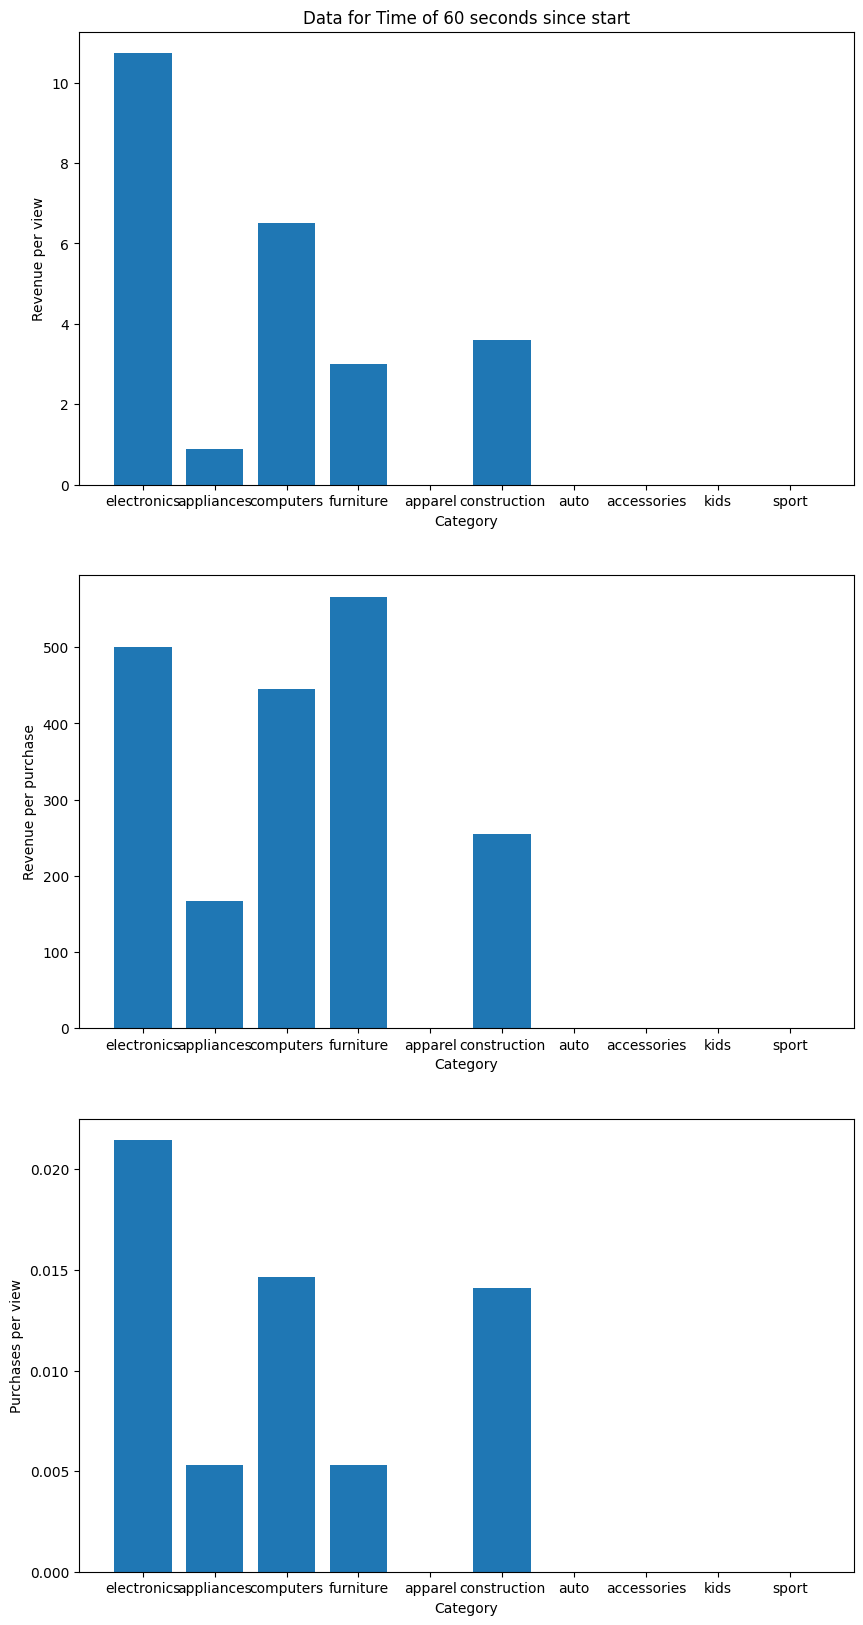

               electronics  appliances  computers  furniture  apparel  \
num_views          1026.00      188.00     205.00      189.0    173.0   
num_purchases        22.00        1.00       3.00        1.0      0.0   
total_revenue     11011.17      167.11    1335.62      566.3      0.0   

               construction  auto  accessories  kids  sport  
num_views             71.00  34.0         20.0  25.0    6.0  
num_purchases          1.00   0.0          0.0   0.0    0.0  
total_revenue        254.78   0.0          0.0   0.0    0.0  


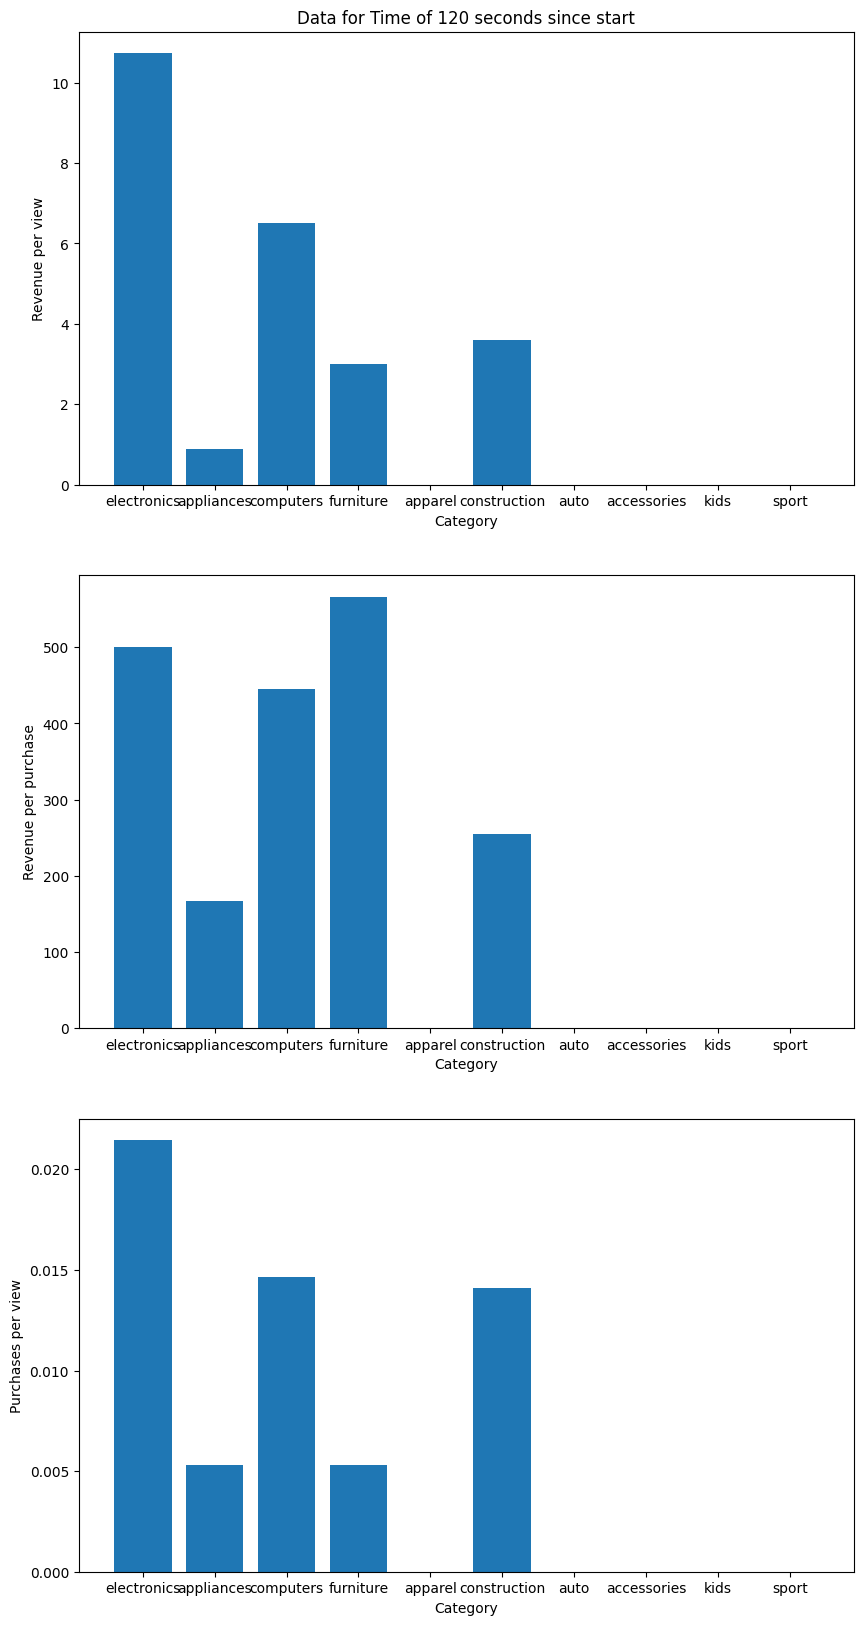

               electronics  appliances  computers  furniture  apparel  \
num_views          1026.00      188.00     205.00      189.0    173.0   
num_purchases        22.00        1.00       3.00        1.0      0.0   
total_revenue     11011.17      167.11    1335.62      566.3      0.0   

               construction  auto  accessories  kids  sport  
num_views             71.00  34.0         20.0  25.0    6.0  
num_purchases          1.00   0.0          0.0   0.0    0.0  
total_revenue        254.78   0.0          0.0   0.0    0.0  


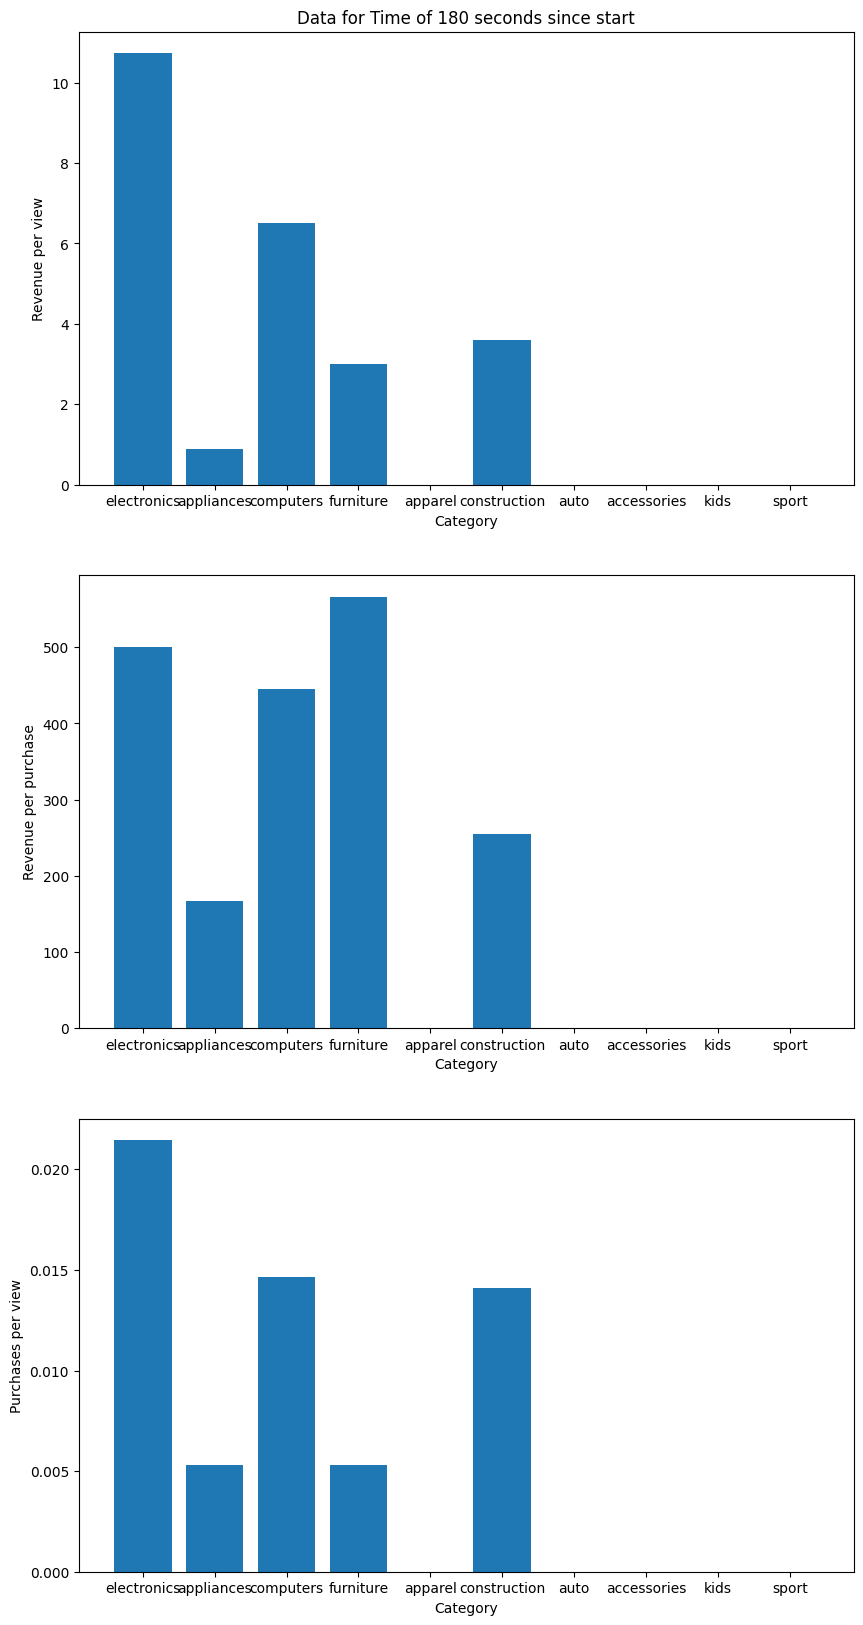

In [ ]:
data_processing = DataProcess()
time_delta = 60
max_time = 200
messages_to_process = 2000

# Create and Start Producing Thread
producer_thread = threading.Thread(target=start_process_file, args=[producer, messages_to_process, False])
producer_thread.start()


# Create and Start Consuming Thread
consumer_thread = threading.Thread(target=read_broker, args=[consumer, data_processing, max_time])
consumer_thread.start()

cur_time = time.time()
for i in range(0, max_time, time_delta):
  if  i != 0:
    data_processing.make_graph(int(time.time() - cur_time))

  temp_time = time.time()
  time.sleep(time_delta - (int(temp_time - cur_time) % time_delta))


# wait for all threads to finish
producer_thread.join()
consumer_thread.join()

data_frame = data_processing.get_cur_dataframe()

In [ ]:
data_frame

,electronics,appliances,computers,furniture,apparel,construction,auto,accessories,kids,sport
num_views,1026.00,188.00,205.00,189.0,173.0,71.00,34.0,20.0,25.0,6.0
num_purchases,22.00,1.00,3.00,1.0,0.0,1.00,0.0,0.0,0.0,0.0
total_revenue,11011.17,167.11,1335.62,566.3,0.0,254.78,0.0,0.0,0.0,0.0
